### 一.利用回归树实现分类

分类也可以用回归树来做，简单说来就是训练与类别数相同的几组回归树，每一组代表一个类别，然后对所有组的输出进行softmax操作将其转换为概率分布，然后再通过交叉熵或者KL一类的损失函数求每颗树相应的负梯度，指导下一轮的训练，以三分类为例，流程如下：   

![avatar](./source/10_梯度提升分类树.png)

### 二.softmax+交叉熵损失，及其梯度求解

分类问题，一般会选择用交叉熵作为损失函数，下面对softmax+交叉熵损失函数的梯度做推导：  



softmax函数在最大熵那一节已有使用，再回顾一下：   

$$
softmax([x_1,x_2,...,x_n])=\frac{1}{\sum_{i=1}^n e^{x_i}}[e^{x_1},e^{x_2},...,e^{x_n}]
$$   

交叉熵在logistic回归有介绍：   

$$
cross\_entropy(y,p)=-\sum_{i=1}^n y_ilog p_i
$$  

将$p_i$替换为$\frac{e^{x_i}}{\sum_{i=1}^n e^{x_i}}$即是我们的损失函数：   

$$
L(x,y)=-\sum_{i=1}^n y_ilog \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}\\
=-\sum_{i=1}^n y_i(x_i-log\sum_{j=1}^n e^{x_j})\\
=log\sum_{i=1}^n e^{x_i}-\sum_{i=1}^ny_ix_i（由于是onehot展开，所以\sum_{i=1}^n y_i=1）
$$  

所以梯度：  

$$
\frac{\partial L(x,y)}{\partial x}=[\frac{e^{x_1}}{\sum_{i=1}^n e^{x_i}}-y_1,\frac{e^{x_2}}{\sum_{i=1}^n e^{x_i}}-y_2,...,\frac{e^{x_n}}{\sum_{i=1}^n e^{x_i}}-y_n]\\
=softmax([x_1,x_2,...,x_n])-[y_1,y_2,...,y_n]
$$  

当然也可以用链式求导的方式，先对交叉熵求偏导然后再对softmax求偏导，注：上面是对单个样本损失函数梯度的求解，$n$是特征维度，不是样本数

### 三.代码实现

In [1]:
import os
os.chdir('../')
from ml_models.tree import CARTRegressor
from ml_models import utils
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class GradientBoostingClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTRegressor(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 扩展class_num组分类器
        self.expand_base_estimators = []

    def fit(self, x, y):
        # 将y转one-hot编码
        class_num = np.amax(y) + 1
        y_cate = np.zeros(shape=(len(y), class_num))
        y_cate[np.arange(len(y)), y] = 1

        # 扩展分类器
        self.expand_base_estimators = [copy.deepcopy(self.base_estimator) for _ in range(class_num)]

        # 拟合第一个模型
        y_pred_score_ = []
        # TODO:并行优化
        for class_index in range(0, class_num):
            self.expand_base_estimators[class_index][0].fit(x, y_cate[:, class_index])
            y_pred_score_.append(self.expand_base_estimators[class_index][0].predict(x))
        y_pred_score_ = np.c_[y_pred_score_].T
        # 计算梯度
        new_y = utils.softmax(y_pred_score_) - y_cate
        # 训练后续模型
        for index in range(1, self.n_estimators):
            y_pred_score = []
            for class_index in range(0, class_num):
                self.expand_base_estimators[class_index][index].fit(x, new_y[:, class_index])
                y_pred_score.append(self.expand_base_estimators[class_index][index].predict(x))
            y_pred_score_ += np.c_[y_pred_score].T * self.learning_rate
            new_y = utils.softmax(y_pred_score_) - y_cate

    def predict_proba(self, x):
        # TODO:并行优化
        y_pred_score = []
        for class_index in range(0, len(self.expand_base_estimators)):
            estimator_of_index = self.expand_base_estimators[class_index]
            y_pred_score.append(
                np.sum(
                    [estimator_of_index[0].predict(x)] +
                    [self.learning_rate * estimator_of_index[i].predict(x) for i in
                     range(1, self.n_estimators - 1)] +
                    [estimator_of_index[self.n_estimators - 1].predict(x)]
                    , axis=0)
            )
        return utils.softmax(np.c_[y_pred_score].T)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

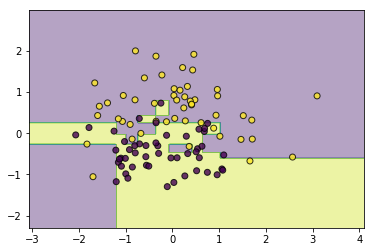

In [3]:
# 同质
classifier = GradientBoostingClassifier(base_estimator=CARTRegressor(),n_estimators=10)
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

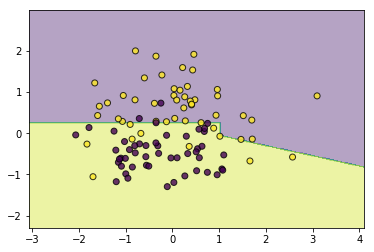

In [4]:
#异质
from ml_models.linear_model import LinearRegression
classifier = GradientBoostingClassifier(base_estimator=[LinearRegression(),LinearRegression(),LinearRegression(),CARTRegressor(max_depth=2)])
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)